In [53]:
import os
import matplotlib.pyplot as plt
import matplotlib
from skimage import io, filters, morphology, measure, feature, future, segmentation, util
from scipy import ndimage
from skimage.color import label2rgb
import os
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.patches as mpatches

## First importing the truss image

In [64]:
%matplotlib inline

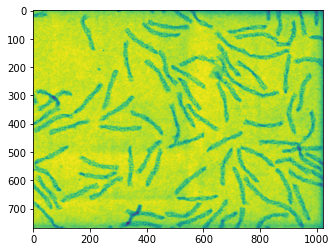

In [65]:
in_folder = 'wireframe-tubes'
in_file = 'tube dimer05.tif'
truss_image = io.imread(os.path.join(in_folder, in_file))
plt.imshow(truss_image)

## Now applying Otsu thresholding to create a sure Bg and a sure Fg image

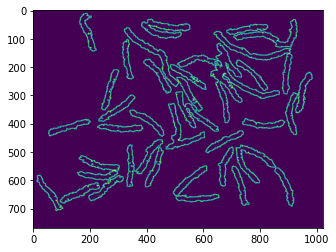

In [66]:
threshold = filters.threshold_otsu(filters.median(truss_image, selem=np.ones(shape=(15, 15))))

binary = (truss_image > threshold) # using '<' because the trusses have a lower intensity value
morphed_binary = morphology.remove_small_holes(morphology.remove_small_objects(~binary, min_size=200), area_threshold=50)

clear = segmentation.clear_border(morphed_binary)
sure_bg = morphology.binary_dilation(clear, np.ones(shape=(5, 5)))
sure_fg = morphology.binary_erosion(clear, np.ones(shape=(1, 1)))
islands = np.logical_and(sure_bg, ~sure_fg)
plt.imshow(islands)

## now skeletonizing individual trusses to create watershed sources, and performing watershed

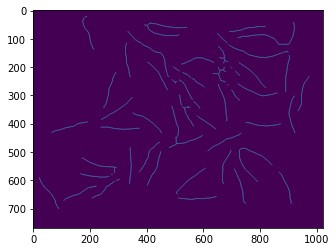

In [67]:
edges = filters.frangi(~sure_fg)
eroded_edges = morphology.skeletonize(morphology.binary_erosion(edges, np.ones(shape=(12, 12))))
plt.imshow(eroded_edges)

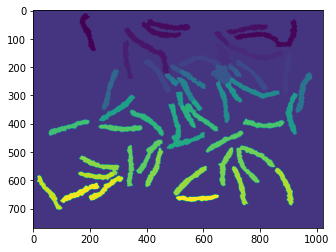

In [68]:
markers = measure.label(eroded_edges)
labels = segmentation.watershed(bg_fg, markers)
plt.imshow(segmentation.mark_boundaries(truss_image, labels))
plt.imshow(labels)

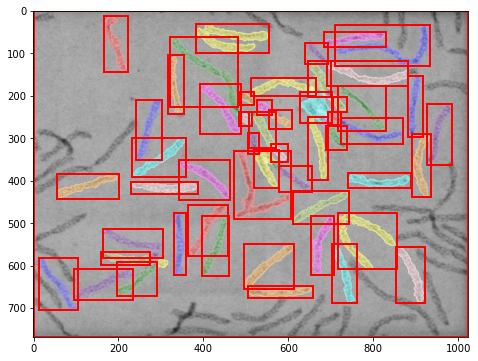

In [69]:
regions = measure.regionprops(labels)
bg_label = regions[area_list.index(np.max(area_list))].label
image_label_overlay = label2rgb(labels, image=truss_image, bg_label=bg_label)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

area_list = [r.area for r in regions]
for region in regions:
    # take regions with large enough areas
    if region.area >= 500:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)